# NHP4 - Non-human primate data master script (replication subject only)
# Cross-trial analysis (typical noise corr and variability analysis)

## Takuya Ito
#### 02/12/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import analysisNHP as analysis


# Set up data parameters

In [2]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for exploratory subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

In [3]:
data = {}
data['area'] = []
data['session'] = []
data['spikesBinned'] = []
data['STA_byTask'] = []
data['taskInfo'] = []
data['mocolInfo'] = []
data['sta_removed'] = []

sessioncount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Loading data for session', session, '|', sessioncount, '/', replication_sessions
    
    taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
    mocolTrials = np.where(taskInfo['task']=='mocol')[0]
    mocolInfo = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
    areas = pd.read_csv(datadir + session + '_areaIndices.csv')

    h5f = h5py.File(datadir + session + '_perArea.h5', 'r')
    for i in range(len(areas)):
        # Columns for h5f are reversed between matlab and python
        data['area'].append(areas['Var1'][i])
        data['session'].append(session)
        spikes_binned = analysis.slidingWindow(h5f['sta'][mocolTrials,:,i].T,binSize=50,shiftSize=10)
        
        # Calculate mean-evoked response, and remove it from each trial
        sta_removed = np.zeros(spikes_binned.shape)
        tasksByTrial = mocolInfo['rule'].astype(str)
        staByTask = {}
        for task in np.unique(tasksByTrial):
            task_ind = np.where(tasksByTrial==task)[0]
            staByTask[task] = np.mean(spikes_binned[:,task_ind],axis=1)
            for ind in task_ind:
                sta_removed[:,ind] = spikes_binned[:,ind] - staByTask[task]
            
        data['spikesBinned'].append(spikes_binned)
        data['sta_removed'].append(sta_removed)
        
        tasksByTrial = mocolInfo['rule'].astype(str)
        staByTask = {}
        for task in np.unique(tasksByTrial):
            task_ind = np.where(tasksByTrial==task)[0]
            staByTask[task] = np.mean(spikes_binned[:,task_ind],axis=1)
        data['STA_byTask'].append(staByTask)
        data['taskInfo'].append(taskInfo)
        data['mocolInfo'].append(mocolInfo)
    h5f.close()
    
    sessioncount += 1
    
data = pd.DataFrame(data)


Loading data for session 100706 | 1 / 39
Loading data for session 100730 | 2 / 39
Loading data for session 100804 | 3 / 39
Loading data for session 100820 | 4 / 39
Loading data for session 100827 | 5 / 39
Loading data for session 101122 | 6 / 39
Loading data for session 101128 | 7 / 39
Loading data for session 101207 | 8 / 39
Loading data for session 101217 | 9 / 39
Loading data for session 110110_01 | 10 / 39
Loading data for session 110115_01 | 11 / 39
Loading data for session 100724 | 12 / 39
Loading data for session 100731 | 13 / 39
Loading data for session 100817 | 14 / 39
Loading data for session 100823 | 15 / 39
Loading data for session 100828 | 16 / 39
Loading data for session 101123 | 17 / 39
Loading data for session 101202 | 18 / 39
Loading data for session 101209 | 19 / 39
Loading data for session 110106 | 20 / 39
Loading data for session 110110_02 | 21 / 39
Loading data for session 100725 | 22 / 39
Loading data for session 100802 | 23 / 39
Loading data for session 100818 | 

# Perform main analyses for replication subject

In [5]:
analysis = reload(analysis)

In [7]:
entropyReplications = {}
entropyReplications['avg_post'] = []
entropyReplications['avg_pre'] = []

jointEntropyReplications = {}
jointEntropyReplications['avg_post'] = []
jointEntropyReplications['avg_pre'] = []

miReplications = {}
miReplications['avg_post'] = []
miReplications['avg_pre'] = []

sesscount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Computing statistics for session', session, '|', sesscount, '/', replication_sessions
    df = data.loc[data['session']==session]
    sta_removed, sta = analysis.concatenateTS(df)
    tmp1, tmp2, tmp3 = analysis.computeInformationTheoreticStats2(df,sta_removed,sta,normalize=False)

    entropyReplications['avg_post'].extend(tmp1['avg_post'])
    entropyReplications['avg_pre'].extend(tmp1['avg_pre'])
    
    jointEntropyReplications['avg_post'].extend(tmp2['avg_post'])
    jointEntropyReplications['avg_pre'].extend(tmp2['avg_pre'])
    
    miReplications['avg_post'].extend(tmp3['avg_post'])
    miReplications['avg_pre'].extend(tmp3['avg_pre'])
    
    sesscount += 1

Computing statistics for session 100706 | 1 / 39
Computing statistics for session 100730 | 2 / 39
Computing statistics for session 100804 | 3 / 39
Computing statistics for session 100820 | 4 / 39
Computing statistics for session 100827 | 5 / 39
Computing statistics for session 101122 | 6 / 39
Computing statistics for session 101128 | 7 / 39
Computing statistics for session 101207 | 8 / 39
Computing statistics for session 101217 | 9 / 39
Computing statistics for session 110110_01 | 10 / 39
Computing statistics for session 110115_01 | 11 / 39
Computing statistics for session 100724 | 12 / 39
Computing statistics for session 100731 | 13 / 39
Computing statistics for session 100817 | 14 / 39
Computing statistics for session 100823 | 15 / 39
Computing statistics for session 100828 | 16 / 39
Computing statistics for session 101123 | 17 / 39
Computing statistics for session 101202 | 18 / 39
Computing statistics for session 101209 | 19 / 39
Computing statistics for session 110106 | 20 / 39
Com

## Compute statistics for exploratory subject

### Plot

In [8]:
df_entropy = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_entropy[area] = {}
    df_entropy[area]['Entropy'] = []
    df_entropy[area]['State'] = []

    tmp = []
    for sess in range(len(entropyReplications['avg_post'])):
        if entropyReplications['avg_post'][sess][i]!=0 and entropyReplications['avg_pre'][sess][i]!=0:
            tmp.append(entropyReplications['avg_post'][sess][i] - entropyReplications['avg_pre'][sess][i])
            df_entropy[area]['Entropy'].append(entropyReplications['avg_pre'][sess][i])
            df_entropy[area]['State'].append('Rest')
            df_entropy[area]['Entropy'].append(entropyReplications['avg_post'][sess][i])
            df_entropy[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
qs = mc.fdrcorrection0(ps)[1]
df_entropy = pd.DataFrame(df_entropy)

# for i in range(len(regions)):
#     area = regions[i]
#     t = ts[i]
#     p = qs[i]
#     df = dof[i]
#     ## Now plot
#     plt.figure(figsize=(5,5))
#     sns.boxplot(x="State",y='Entropy',
#                palette=["#add8e6","#f08080"],
#                data=df_entropy[area],whis=np.inf)
# #     sns.stripplot(x="State",y='Entropy',
# #                palette=["#add8e6","#f08080"],
# #                data=df_entropy[area], alpha=0.5)

#     if p < 0.0001: 
#         p = '$p < 0.0001$'
#     else:
#         p = '$p = ' + str(round(p,3)) + '$'
#     plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontname='FreeSans',fontsize=24)
#     plt.ylabel('Entropy',fontsize=20, fontname='FreeSans')
#     plt.xlabel('State', fontsize=20,fontname='FreeSans')
#     plt.xticks(fontsize=18,fontname='FreeSans')
#     plt.ylim([np.min(df_entropy[area]['Entropy'])-np.std(df_entropy[area]['Entropy']),np.max(df_entropy[area]['Entropy'])+3*np.std(df_entropy[area]['Entropy'])]);
#     plt.tight_layout()
#     plt.savefig('NHP6s_' + area + '_spkEntropy_Replication.pdf')

# Perform global analyses (i.e., averaged across all recordings)

In [9]:
globalEntropy = []

sesscount = 0
for trial in range(len(entropyReplications['avg_pre'])):
    
    tmp_entropy = np.zeros((2,))
    zero_ind = np.where(entropyReplications['avg_post'][trial]!=0)[0]
    
    tmp_entropy[0] = np.mean(entropyReplications['avg_pre'][trial][zero_ind])
    tmp_entropy[1] = np.mean(entropyReplications['avg_post'][trial][zero_ind])
    globalEntropy.append(tmp_entropy)
    
    
    sesscount += 1
    
globalEntropy = np.asarray(globalEntropy)

## for averaged joint entropy

Average joint entropy rest 1.81058610901
Average joint entropy task 1.81877671912
task v rest 	diff = 0.00819061010664
	t = 2.91980580063 | p = 0.00355416471373


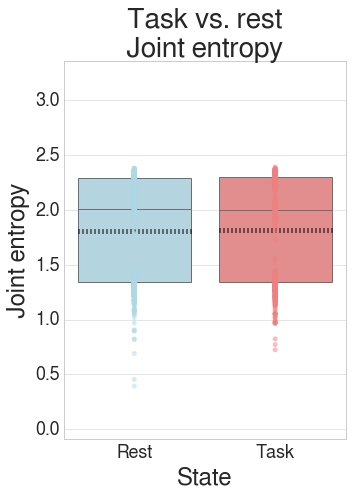

In [10]:
df_jointentropy = {}
df_jointentropy['State'] = []
df_jointentropy['Joint Entropy'] = []
df_jointentropy['Session'] = []

for sess in range(len(jointEntropyReplications['avg_pre'])):
    tril_ind = np.tril_indices(jointEntropyReplications['avg_pre'][sess].shape[0],k=1)
    df_jointentropy['State'].append('Rest')
    df_jointentropy['Joint Entropy'].append(np.mean(jointEntropyReplications['avg_pre'][sess][tril_ind]))
    df_jointentropy['Session'].append(sess)
    
    df_jointentropy['State'].append('Task')
    df_jointentropy['Joint Entropy'].append(np.mean(jointEntropyReplications['avg_post'][sess][tril_ind]))
    df_jointentropy['Session'].append(sess)
    
df_jointentropy = pd.DataFrame(df_jointentropy)
    
# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_jointentropy.loc[df_jointentropy['State']=='Rest']
tmptask = df_jointentropy.loc[df_jointentropy['State']=='Task']
t, p = stats.ttest_rel(tmptask['Joint Entropy'],tmprest['Joint Entropy'])
print 'Average joint entropy rest', np.mean(tmprest['Joint Entropy'].values)
print 'Average joint entropy task', np.mean(tmptask['Joint Entropy'].values)
print 'task v rest',
print '\tdiff =', np.mean(tmptask['Joint Entropy'].values)-np.mean(tmprest['Joint Entropy'].values)
print '\tt =', t, '| p =', p

sns.boxplot(data=[tmprest['Joint Entropy'],tmptask['Joint Entropy']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.stripplot(data=[tmprest['Joint Entropy'],tmptask['Joint Entropy']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
if str(round(p,3))=="0.0": 
    p = '$p < 0.0001$'
else:
    p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nJoint entropy',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Joint entropy',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_jointentropy['Joint Entropy'])-np.std(df_jointentropy['Joint Entropy']),np.max(df_jointentropy['Joint Entropy'])+2*np.std(df_jointentropy['Joint Entropy'])]);
plt.yticks(fontname='FreeSans',fontsize=18)
plt.tight_layout()
plt.savefig('NHP6s_' + area + '_jointEntropy_Replication.pdf')

Average mutual information rest 0.4749535919
Average mutual information task 0.483585928388
task v rest 	t = 3.93604057332 | p = 8.65831773153e-05


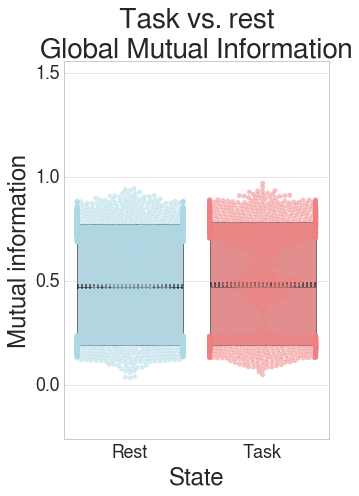

In [11]:
df_mi = {}
df_mi['State'] = []
df_mi['Mutual Information'] = []
df_mi['Session'] = []

for sess in range(len(miReplications['avg_pre'])):
    tril_ind = np.tril_indices(miReplications['avg_pre'][sess].shape[0],k=1)
    df_mi['State'].append('Rest')
    df_mi['Mutual Information'].append(np.mean(miReplications['avg_pre'][sess][tril_ind]))
    df_mi['Session'].append(sess)
    
    df_mi['State'].append('Task')
    df_mi['Mutual Information'].append(np.mean(miReplications['avg_post'][sess][tril_ind]))
    df_mi['Session'].append(sess)
    
df_mi = pd.DataFrame(df_mi)
    
# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_mi.loc[df_mi['State']=='Rest']
tmptask = df_mi.loc[df_mi['State']=='Task']
t, p = stats.ttest_rel(tmptask['Mutual Information'],tmprest['Mutual Information'])
print 'Average mutual information rest', np.mean(tmprest['Mutual Information'].values)
print 'Average mutual information task', np.mean(tmptask['Mutual Information'].values)
print 'task v rest',
print '\tt =', t, '| p =', p

sns.boxplot(data=[tmprest['Mutual Information'],tmptask['Mutual Information']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Mutual Information'],tmptask['Mutual Information']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
if str(round(p,3))=="0.0": 
    p = '$p < 0.0001$'
else:
    p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nGlobal Mutual Information',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Mutual information',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.yticks(fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_mi['Mutual Information'])-np.std(df_mi['Mutual Information']),np.max(df_mi['Mutual Information'])+2*np.std(df_mi['Mutual Information'])]);
plt.tight_layout()

### Plot

Entropy Post- vs. Pre-stim:
Entropy diff: 0.0128980537048
	t = 3.012 | p = 0.00264019648139


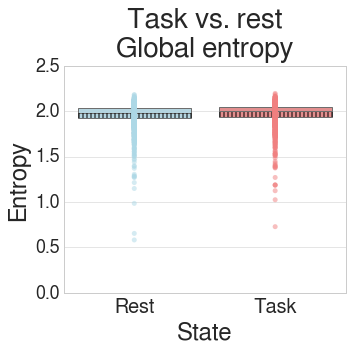

In [12]:
t, p = stats.ttest_rel(globalEntropy[:,1],globalEntropy[:,0])
print 'Entropy Post- vs. Pre-stim:'
print 'Entropy diff:', np.mean(globalEntropy[:,1]) - np.mean(globalEntropy[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.stripplot(data=[globalEntropy[:,0], globalEntropy[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalEntropy[:,0], globalEntropy[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(entropyReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal entropy',fontsize=28, y=1.02)
plt.ylabel('Entropy',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalEntropy[:,1])-np.std(globalEntropy[:,1]),np.max(globalEntropy[:,0])+1*np.std(globalEntropy[:,0])]);
plt.tight_layout()
# plt.savefig('NHP6s_' + 'globalVar_Replication.pdf')


